# Curvature: Numerical vs Analytical Comparison


In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.linalg import eigh
from sklearn.decomposition import PCA
import sklearn.neighbors as sknn
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.sparse.csgraph import connected_components
import warnings
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import issparse
from microstructpy import geometry
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pltlab
import warnings

warnings.filterwarnings('ignore')

c:\Users\User\Documents\Doutorado\shape-operator-based-umap\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def gs(X, row_vecs=True, norm = True):
    """
    Gram-Schmidt ortogonalization
    """
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T
    
def fit_nsphere(X):
    sphere = geometry.n_sphere.NSphere.best_fit(X)
    
    return sphere.radius
    
def robust_cov_eig(amostras, min_reg=1e-6):
    m = amostras.shape[1]
    if amostras.shape[0] <= 1:
        # Patch muito pequeno: retorna identidade
        return np.ones(m), np.eye(m)
    cov = np.cov(amostras.T)
    # Garante simetria numérica
    cov = (cov + cov.T) / 2
    # Regularização adaptativa
    reg = min_reg
    while True:
        try:
            vals, vecs = np.linalg.eigh(cov + reg * np.eye(m))
            break
        except np.linalg.LinAlgError:
            reg *= 10
            if reg > 1:
                # fallback: identidade
                return np.ones(m), np.eye(m)
    return vals, vecs

def SphereCurvature(dados,k,d=None):
    n = dados.shape[0]
    m = dados.shape[1]
    knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')
    A = knnGraph.toarray()
    n_connected_components, labels = connected_components(knnGraph)
    if n_connected_components > 1:
        # Corrigir componentes desconexas
        nbg = _fix_connected_components(
            X=dados,
            graph=knnGraph,
            n_connected_components=n_connected_components,
            component_labels=labels,
            mode="distance",
            metric='euclidean',  

        )

        A = nbg.toarray()

    R = []

    for i in range(n):
        vizinhos = A[i, :] - np.mean(A[i, :],axis=0)
        indices = vizinhos.nonzero()[0]
        r_i = fit_nsphere(dados[indices])
        ## A curvatura da esfera em R^d é 1/r^d, mas precisamos saber d a priori
        R.append(1/r_i**2)


    return R
    
def KGraph(dados, k, d, option, alpha=0.5, constrained=True):
    n = dados.shape[0]
    m = dados.shape[1]
    matriz_pcs = np.zeros((n, m, m))
    knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')
    A = knnGraph.toarray()
    n_connected_components, labels = connected_components(knnGraph)
    if n_connected_components > 1:
        # ...existing code for fixing components...
        pass  # (mantenha o seu _fix_connected_components)
    for i in range(n):
        vizinhos = A[i, :]
        indices = vizinhos.nonzero()[0]
        if len(indices) < 2:
            matriz_pcs[i, :, :] = np.eye(m)
        else:
            amostras = dados[indices] - np.mean(dados[indices], axis=0)
            vals, vecs = robust_cov_eig(amostras)
            ordem = vals.argsort()
            maiores_autovetores = vecs[:, ordem[::-1]]
            matriz_pcs[i, :, :] = maiores_autovetores
        
    # Defines the patch-based matrix (graph)
    B = A.copy()
    for i in range(n):
        for j in range(i,n):
            if B[i, j] > 0:

                if constrained == True:
                # CONSTRAINED K-ISOMAP TO GET FIRST d PRINCIPAL COMPONENTS
                    delta = norm(matriz_pcs[i, :, :d+1] - matriz_pcs[j, :, :d+1], axis=0)
                else:
                    delta = norm(matriz_pcs[i, :, :] - matriz_pcs[j, :, :], axis=0)

                ##### Functions of the principal curvatures (definition of the metric)
                # We must choose one single option for each execution
                if option == 'norm':
                    B[i, j] = norm(delta)                  # metric A0 - Norms of the principal curvatures
                elif option == 'sum':
                    B[i, j] = np.sum(delta)
                elif option == 'first':
                    B[i, j] = delta[0]                      # metric A1 - Curvature of the first principal component
                elif option == 'last':
                    B[i, j] = delta[-1]                    # metric A2 - Curvature of the last principal component
                elif option == 'avg_first_last':
                    B[i, j] = (delta[0] + delta[-1])/2     # metric A3 - Average between the curvatures of first and last principal components
                elif option == 'mean':
                    B[i, j] = np.sum(delta)/len(delta)     # metric A4 - Mean curvature
                elif option == 'max':
                    B[i, j] = max(delta)                   # metric A5 - Maximum curvature
                elif option == 'min':
                    B[i, j] = min(delta)                   # metric A6 - Minimum curvature
                elif option == 'product_min_max':
                    B[i, j] = min(delta)*max(delta)        # metric A7 - Product between minimum and maximum curvatures
                elif option == 'difference_max_min':
                    B[i, j] = max(delta) - min(delta)      # metric A8 - Difference between maximum and minimum curvatures
                elif option == 'exponential':
                    B[i, j] = 1 - np.exp(-delta.mean())     # metric A9 - Negative exponential kernel
                elif option == 'mixed': 
                    B[i, j] = ((1-alpha)*(A[i, j]/sum(A[i, :])) + alpha*norm(delta))      # alpha = 0 => regular ISOMAP, alpha = 1 => K-ISOMAP 
            
            # Simmetry
            B[j,i]=B[i,j]

    return B

def _fix_connected_components(
    X,
    graph,
    n_connected_components,
    component_labels,
    mode="distance",
    metric="euclidean",
    **kwargs):
    """
    Função do sklearn para corrigir componentes desconexas
    """
    for i in range(n_connected_components):
        idx_i = np.flatnonzero(component_labels == i)
        Xi = X[idx_i]
        for j in range(i):
            idx_j = np.flatnonzero(component_labels == j)
            Xj = X[idx_j]

            if metric == "precomputed":
                D = X[np.ix_(idx_i, idx_j)]
            else:
                D = pairwise_distances(Xi, Xj, metric=metric, **kwargs)

            ii, jj = np.unravel_index(D.argmin(axis=None), D.shape)
            if mode == "connectivity":
                graph[idx_i[ii], idx_j[jj]] = 1
                graph[idx_j[jj], idx_i[ii]] = 1
            elif mode == "distance":
                graph[idx_i[ii], idx_j[jj]] = D[ii, jj]
                graph[idx_j[jj], idx_i[ii]] = D[ii, jj]

    return graph

def Curvature_Estimation_Opt(dados, k, d=None):

    n = dados.shape[0]
    m = dados.shape[1]

    if d is None:
        d = m
    
    curvatures = np.zeros(n)

    knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='connectivity', include_self=False)
    A = knnGraph.toarray()

    for i in range(n):
        vizinhos = A[i, :]
        indices = vizinhos.nonzero()[0]
        if len(indices) < 2:
            I = np.eye(m)
            Wpca = np.eye(m)
        else:
            amostras = dados[indices] - np.mean(dados[indices], axis=0)
            vals, vecs = robust_cov_eig(amostras)
            ordem = vals.argsort()
            Wpca = vecs[:, ordem[::-1]]

        # Segunda forma fundamental 
        Squared = np.zeros((m, m))
        ncol = (m*(m-1))//2
        Cross = np.zeros((m, ncol))
        for j in range(0, m):
            Squared[:, j] = Wpca[:, j]**2
        col = 0
        for j in range(0, m):
            for l in range(j, m):
                if j != l:
                    Cross[:, col] = Wpca[:, j]*Wpca[:, l]
                    col += 1
        Wpca_aug = np.column_stack((np.ones(m), Wpca))
        Wpca_aug = np.hstack((Wpca_aug, Squared))
        Wpca_aug = np.hstack((Wpca_aug, Cross))
        Q = gs(Wpca_aug)
        H = Q[:, (m+1):]
        II = np.dot(H, H.T)
        I = np.eye(m) if len(indices) < 2 else np.cov(amostras.T) + 1e-3*np.eye(m)
        # Nesta versão, a primeira forma fundamental é invertida
        I = np.linalg.inv(I)
        try:
            S = -np.dot(II, I)
            curvatures[i] = abs(np.linalg.det(S))
        except np.linalg.LinAlgError:
            curvatures[i] = 0
    return curvatures


def Curvature_Estimation_Old(dados,k,d=None):
    n = dados.shape[0]
    m = dados.shape[1]
    # Se tiver mais de 80 atributos, aplica PCA antes de calcular curvaturas
    if m > 200:
        m = 50
        model = PCA(n_components=m)
        dados = model.fit_transform(dados)
    elif m > 80:
        m = 30
        model = PCA(n_components=m)
        dados = model.fit_transform(dados)        
    # Primeira e segunda formas fundamentais
    I = np.zeros((m, m))
    Squared = np.zeros((m, m))
    ncol = (m*(m-1))//2
    Cross = np.zeros((m, ncol))
    # Second fundamental form
    II = np.zeros((m, m))
    S = np.zeros((m, m))
    curvatures = np.zeros(n)
    # Generate KNN graph
    knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='connectivity', include_self=False)
    A = knnGraph.toarray()
    # Computes the means and covariance matrices for each patch
    for i in range(n):
        ######## Patch P_i
        vizinhos = A[i, :]
        indices = vizinhos.nonzero()[0]
        ##########################################
        ######## Estima primeira forma fundamental
        ######## Estudar o efeito da centralização, se muda algo
        amostras = dados[indices] - np.mean(dados[indices], axis=0)
        ni = len(indices)
        if ni > 1:
            # Primeira forma fundamental em i
            I = np.cov(amostras.T)
            I = I + 0.0001*np.eye(I.shape[0])   # Regulariza
        else:
            I = np.eye(m)      # pontos isolados = identidade
        # Compute the eigenvectors
        v, w = np.linalg.eig(I)
        # Sort the eigenvalues
        ordem = v.argsort()
        # Select the eigenvectors in decreasing order (in columns)
        Wpca = w[:, ordem[::-1]]
        # Estima segunda forma fundamental
        for j in range(0, m):
            Squared[:, j] = Wpca[:, j]**2
        col = 0
        for j in range(0, m):
            for l in range(j, m):
                if j != l:
                    Cross[:, col] = Wpca[:, j]*Wpca[:, l]
                    col += 1
        # Adiciona coluna de 1's, squared e cross
        Wpca = np.column_stack((np.ones(m), Wpca))
        Wpca = np.hstack((Wpca, Squared))
        Wpca = np.hstack((Wpca, Cross))
        # Gram-Schmidt ortogonalization
        Q = gs(Wpca)
        # Discard the first m columns of H
        H = Q[:, (m+1):]
        # Segunda forma fundamental
        II = np.dot(H, H.T)
        # Nesta versão, a primeira forma fundamental não é invertida
        # I = np.linalg.inv(I)
        S = -np.dot(II, I)
        curvatures[i] = np.linalg.det(S)        # curvatura Gaussiana
        #curvatures[i] = np.trace(S)            # curvatura média
    return curvatures

def Curvature_Estimation_Lev(dados,k,d=None):
    # Levada - kkNN artigo
    n = dados.shape[0]
    m = dados.shape[1]
    # First fundamental form
    I = np.zeros((m, m))
    Squared = np.zeros((m, m))
    ncol = (m*(m-1))//2
    Cross = np.zeros((m, ncol))
    # Second fundamental form
    II = np.zeros((m, m))
    S = np.zeros((m, m))
    curvatures = np.zeros(n)
    # Generate KNN graph
    knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='connectivity', include_self=False)
    A = knnGraph.toarray()    
    # Computes the means and covariance matrices for each patch
    for i in range(n):       
        vizinhos = A[i, :]
        indices = vizinhos.nonzero()[0]
        #  Computation of the first fundamental form
        amostras = dados[indices]
        ni = len(indices)
        if ni > 1:
            I = np.cov(amostras.T)
            I = I + 1e-19*np.eye(I.shape[0])
        else:
            I = np.eye(m)      # isolated points
        # Compute the eigenvectors
        v, w = np.linalg.eig(I)
        # Sort the eigenvalues
        ordem = v.argsort()
        # Select the eigenvectors in decreasing order (in columns)
        Wpca = w[:, ordem[::-1]]
        # Computation of the second fundamental form
        for j in range(0, m):
            Squared[:, j] = Wpca[:, j]**2
        col = 0
        for j in range(0, m):
            for l in range(j, m):
                if j != l:
                    Cross[:, col] = Wpca[:, j]*Wpca[:, l]
                    col += 1
        # Add a column of ones
        Wpca = np.column_stack((np.ones(m), Wpca))
        Wpca = np.hstack((Wpca, Squared))
        Wpca = np.hstack((Wpca, Cross))
        # Gram-Schmidt ortogonalization
        Q = gs(Wpca)
        #Q = Wpca
        # Discard the first m columns of H
        H = Q[:, (m+1):]        
        II = np.dot(H, H.T)
        I = np.linalg.inv(I)
        S = -np.dot(II, I)
        curvatures[i] = abs(np.linalg.det(S))
    return curvatures

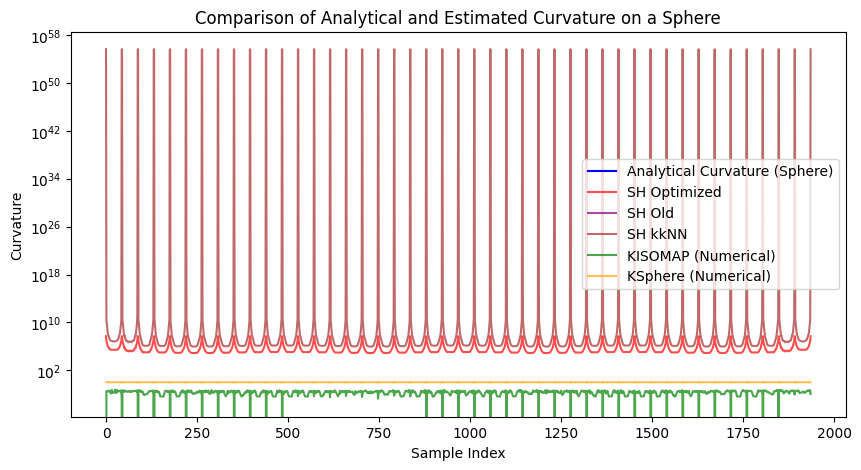

In [10]:
r = 1.0
n_points = 2000

phi = np.linspace(0, np.pi, int(np.sqrt(n_points)))
theta = np.linspace(0, 2 * np.pi, int(np.sqrt(n_points)))
phi, theta = np.meshgrid(phi, theta)
phi = phi.flatten()
theta = theta.flatten()

X = np.zeros((phi.size, 3))
X[:, 0] = r * np.sin(phi) * np.cos(theta)
X[:, 1] = r * np.sin(phi) * np.sin(theta)
X[:, 2] = r * np.cos(phi)

K_true = 1 / (r ** 2)


K_old = Curvature_Estimation_Old(X, k=20,d=2)

K_opt = Curvature_Estimation_Opt(X, k=20,d=2)

K_lev = Curvature_Estimation_Lev(X, k=20,d=2)

K_iso = KGraph(X, k=20, d=2, option='sum', constrained=True)  

K_iso_sum = [np.mean(K_iso[i,:]) for i in range(0,X.shape[0])]

K_sph = SphereCurvature(X, k=20)

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(K_true, label='Analytical Curvature (Sphere)', color='blue')
plt.plot(K_opt, label='SH Optimized', color='red', alpha=0.7)
plt.plot(K_old, label='SH Old', color='purple', alpha=0.7)
plt.plot(K_lev, label='SH kkNN', color='brown', alpha=0.7)
plt.plot(K_iso_sum, label='KISOMAP (Numerical)', color='green', alpha=0.7)
plt.plot(K_sph, label='KSphere (Numerical)', color='orange', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Curvature')
plt.title('Comparison of Analytical and Estimated Curvature on a Sphere')
plt.legend()
plt.yscale('log') 
plt.show()